## Comparing GNN Approaches in Molecule Identification

In [ ]:
pip install spektral

In [2]:
pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 22.5 MB/s eta 0:00:00


Firstly, we will show how original data downloaded from CompTox database via scrapping tehnique is converted into graph format

In [3]:
from rdkit import Chem
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit import Chem, DataStructs

Cloning github repository where the original data is

In [4]:
!git clone https://github.com/ivanna1109/DSC_Conference2024Materials

Cloning into 'DSC_Conference2024Materials'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 34 (delta 16), reused 33 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (34/34), 4.44 MiB | 13.56 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [5]:
assays = [
    "ATG_PPARg_TRANS_dn",
    "ATG_PPARg_TRANS_up",
    "TOX21_PPARg_BLA_antagonist_ratio",
    "TOX21_PPARg_BLA_Agonist_ratio",
    "NVS_NR_hPPARg",
    "ERF_ENZ_hCYP19A1_dn",
    "NVS_ADME_hCYP19A1",
    "NVS_ADME_hCYP19A1_Activator",
    "TOX21_Aromatase_Inhibition",
    "CEETOX_H295R_ESTRADIOL_dn",
    "CEETOX_H295R_ESTRADIOL_noMTC_dn",
    "CEETOX_H295R_ESTRADIOL_noMTC_up",
    "CEETOX_H295R_ESTRADIOL_up",
    "CEETOX_H295R_ESTRONE_dn",
    "CEETOX_H295R_ESTRONE_noMTC_dn",
    "CEETOX_H295R_ESTRONE_noMTC_up",
    "CEETOX_H295R_ESTRONE_up"
]

effects = [
    "dn",
    "up",
    "dn",
    "up",
    "dn",
    "dn",
    "dn",
    "up",
    "dn",
    "dn",
    "dn",
    "up",
    "up",
    "dn",
    "dn",
    "up",
    "up"
]

This code processes data on various biochemical tests (assays) and their results, combining them into several DataFrames. It also prepares data on SMILES strings (representations of molecules) and removes duplicates. In the end, we obtain a list of DataFrames (dfs) and a consolidated DataFrame with SMILES data (smiles).

In [6]:
# find all matching

dfs = []
smiles = []

for assay, effect in zip(assays, effects):
    path = f"DSC_Conference2024Materials/data/{assay}.csv"
    df = pd.read_csv(path)
    # print(df["smiles"].isnull().sum())

    s = df[["preferredName", "smiles"]].copy()
    s.index = s["preferredName"]
    del s["preferredName"]
    smiles.append(s)

    df = df[["preferredName", "hitc"]] # only leave these two columns

    df = df[df["hitc"] != -1] # 22.9.2022.: remove inconclusive results

    df[f"effect_{assay}"] = -1 if effect == "dn" else 1

    df["hitc"] *= df[f"effect_{assay}"]

    del df[f"effect_{assay}"]

    df.index = df["preferredName"]
    del df["preferredName"] # set index to name and remove the column name
    df.columns = [assay] # set type (only remaining column) to name of assay

    dfs.append(df)

# save for later
smiles = pd.concat(smiles, axis=0)
smiles = smiles[~smiles.index.duplicated(keep='first')]

In [7]:
smiles.isnull().sum() # should be zero, all smiles are fixed

,0
smiles,0


In [8]:
dfs[12].value_counts() #example of one csv file in dataset

,count
CEETOX_H295R_ESTRADIOL_up,
0,514
1,58


Method for converting smiles representation of molecule into graph structure

In [9]:

def smiles_to_graph(smiles_str, label):
    mol = Chem.MolFromSmiles(smiles_str)
    label_type = {
        0: 'inactive',
        1: 'partially active',
        2: 'active'
    }
    G = nx.Graph(label=label_type.get(label, -1))

    bond_type_mapping = {
        Chem.BondType.SINGLE: 1,
        Chem.BondType.DOUBLE: 2,
        Chem.BondType.TRIPLE: 3,
        Chem.BondType.AROMATIC: 4
    }

    for atom in mol.GetAtoms():
        atom_idx = atom.GetIdx()
        atom_symbol = atom.GetSymbol()
        #print(f"Simbol atoma {atom_symbol}")
        atom_degree = atom.GetDegree()
        G.add_node(atom_idx, atom_label=str(atom_symbol), degree=atom_degree)

    for bond in mol.GetBonds():
        bond_type = bond.GetBondType()
        encoded_bond_type = bond_type_mapping.get(bond_type, 0)
        G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), weight=encoded_bond_type, bond_type=encoded_bond_type)

    return G

In [13]:
graphs_list = list()
bad_smiles = []

In [10]:
def get_graph(row):
    print("Processing row:", row)
    try:
        molecule_label = 'active'
        if row.label == 0: molecule_label = 'inactive'
        elif row.label == 1: molecule_label = 'partially_active'
        sm = smiles.loc[row.name, 'smiles']
        print(f"SMILES for {row.name} which is {molecule_label}: {sm}")

        if pd.isna(sm):
            raise ValueError("SMILES string is NaN")
        graph = smiles_to_graph(sm, row.label)
        graphs_list.append(graph)
        return graph
        """ all molecules are saved into separate gml files
        gml_file = f"molecules/molecule_{row.name}_{row.label}.gml"
        nx.write_gml(graph_smile, gml_file)
        print(f"Graf za {sm} sačuvan je u {gml_file}")
        """
    except Exception as e:
        print(f"Bad smiles string for {row.name}: {e}")
        bad_smiles.append(row.name)

In [11]:
def visualize_graph(G):
    plt.figure(figsize=(12, 6))
    pos = nx.spring_layout(G)

    nx.draw_networkx(G, pos, with_labels=False, node_color='lightblue', node_size=500, edge_color='gray')

    node_labels = nx.get_node_attributes(G, 'atom_label')
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12, font_color='black')

    edge_labels = nx.get_edge_attributes(G, 'bond_type')
    edge_labels_str = {
        (u, v): {1: "S", 2: "D", 3: "T", 4: "A"}.get(edge_labels[(u, v)], "Unknown")
        for u, v in edge_labels
    }
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels_str, font_color='red')

    graph_label = G.graph.get('label', 'No Label')
    plt.text(0.5, 1.05, f"Label: {graph_label}", fontsize=15, ha='center', transform=plt.gca().transAxes)

    plt.show()

<ipython-input-14-0560320ee2d7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assay["label"] = np.where(assay["label"] == 1, 2, assay["label"]) # up
<ipython-input-14-0560320ee2d7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assay["label"] = np.where(assay["label"] == -1, 1, assay["label"]) # dn
<ipython-input-14-0560320ee2d7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

label
0.0    21095
2.0     1320
1.0     1066
Name: count, dtype: int64
label
0.0    7306
1.0    1302
2.0       3
Name: count, dtype: int64
Processing row: label    1.0
Name: Tetrahydrocurcumin, dtype: float64
SMILES for Tetrahydrocurcumin which is partially_active: COC1=CC(CCC(=O)CC(=O)CCC2=CC(OC)=C(O)C=C2)=CC=C1O


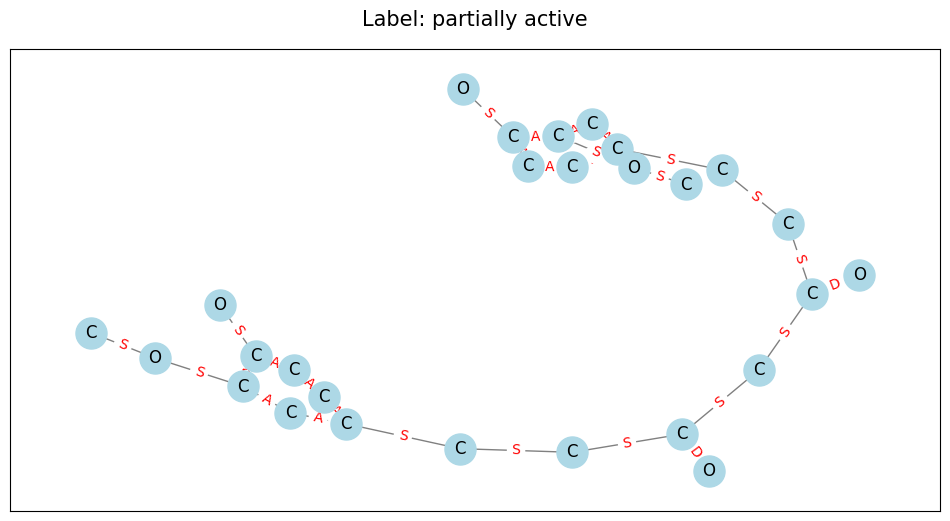

ok: 1
bad: []
bad count: 0


In [14]:
plt_count = 1
for assay, name in zip([pd.concat(dfs[0:5]), pd.concat(dfs[5:9]), pd.concat(dfs[9:17])],
                       ["ke1", "ke2", "ke3"]):

    assay["label"] = assay.sum(axis=1)

    assay = assay[["label"]]

    assay["label"] = np.where(assay["label"] == 1, 2, assay["label"]) # up
    assay["label"] = np.where(assay["label"] == -1, 1, assay["label"]) # dn

    print(assay["label"].value_counts())

    #assay.apply(lambda mol: get_graph(mol), axis=1)
    molecule = assay.iloc[0]  # Take only one molecule for demonstration
    if molecule.label == 1:
        graph = get_graph(molecule)
        visualize_graph(graph)

        print("ok:", len(graphs_list))
        print("bad:", bad_smiles)
        print("bad count:", len(bad_smiles))
        break

Now, we will store this one example molecule into h5 file

In [15]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
elements = ['O', 'C', 'Au', 'Yb', 'Ba', 'Mo', 'Pd', 'Hg',
            'H', 'Nd', 'Dy', 'Se', 'Co', 'Li', 'Br', 'Bi', 'Cr', 'Ge',
              'Ag', 'Mg', 'Zr', 'Pt', 'Be', 'Ni', 'Cl', 'Gd', 'Sc', 'Tl',
              'Zn', 'P', '*', 'K', 'N', 'As', 'Ti', 'Sr', 'Sn', 'Na', 'Cd',
              'Al', 'Cu', 'Si', 'F', 'Eu', 'Pb', 'Sb', 'V', 'S', 'Fe', 'B',
              'I', 'Ca', 'In', 'Mn']  # This is all possible chemical elements that could occur in any molecule
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(np.array(elements).reshape(-1, 1))

OneHotEncoder(sparse_output=False)

First, we create Spektral Dataset which is consisted of graph molecules. Also, Data augmentation using graph isomorphism is done in this process

In [25]:
class MoleculeDataset(Dataset):
    def __init__(self, nx_graphs):
        self.graphs = nx_graphs
        super().__init__()

    def read(self):
        graphs = []
        for G in self.graphs:
            x = []

            node_mapping = {node: i for i, node in enumerate(G.nodes)}
            for node in G.nodes:

                atom_type = encoder.transform([[G.nodes[node]['atom_label']]])[0]

                # Ponderisani stepen čvora od svih suseda (dakle neusmeren je graf, tezina grana na susedima se cuva kao feature cvora)
                weighted_degree_ng = sum(int(G.edges[node, neighbor]['bond_type']) for neighbor in G.neighbors(node))

                num_neighbors = G.degree[node]

                #pravimo feature za trenutni cvor
                node_feature = np.concatenate([atom_type, [weighted_degree_ng, num_neighbors]])

                x.append(node_feature) #dodajemo u listu cvorova
            x = np.array(x)
            a = nx.to_numpy_array(G)
            molecule_name = G.graph.get('molecule_name', 'unknown')
            graphs.append(Graph(x=x, a=a, y=G.graph['label'], molecule_name=molecule_name))
            if (G.graph.get('label')=='active' or G.graph.get('label')=='partially active'):
                for i in range(4): #vrati ovo posle na 3
                    nodes = list(G.nodes)
                    random.shuffle(nodes)
                    mapping = {old_label: new_label for old_label, new_label in zip(G.nodes, nodes)}
                    G_iso = nx.relabel_nodes(G, mapping)
                    sorted_nodes = sorted(mapping.keys(), key=lambda x: mapping[x])
                    sorted_indices = [list(G.nodes).index(node) for node in sorted_nodes]
                    isomorphic_am = nx.adjacency_matrix(G_iso).toarray()
                    A_sorted = isomorphic_am[np.ix_(sorted_indices, sorted_indices)]
                    new_G_iso = nx.from_numpy_array(A_sorted)
                    node_labels = nx.get_node_attributes(G_iso, 'atom_label')

                    inverse_mapping = {v: k for k, v in mapping.items()}
                    for idx, node in enumerate(sorted_indices):
                        new_G_iso.nodes[node]['atom_label'] = node_labels[str(node)]
                    x = []
                    for node in new_G_iso.nodes:

                        atom_type = encoder.transform([[new_G_iso.nodes[node]['atom_label']]])[0]

                    # Ponderisani stepen čvora od svih suseda (dakle neusmeren je graf, tezina grana na susedima se cuva kao feature cvora)
                        weighted_degree_ng = sum(int(A_sorted[node, neighbor]) for neighbor in new_G_iso.neighbors(node))

                        num_neighbors = new_G_iso.degree[node]

                    #pravimo feature za trenutni cvor
                        node_feature = np.concatenate([atom_type, [weighted_degree_ng, num_neighbors]])

                        x.append(node_feature) #dodajemo u listu cvorova
                    x = np.array(x)
                    a = nx.to_numpy_array(new_G_iso)
                    molecule_name = G.graph.get('molecule_name', 'unknown')
                    new_G_iso.graph['molecule_name'] = G.graph['molecule_name']
                    graphs.append(Graph(x=x, a=a, y=G.graph['label'], molecule_name=molecule_name))

        return graphs

In [23]:
import os

nx_graphs = []
gml_file ='DSC_Conference2024Materials/molecule_example/molecule_Tetrahydrocurcumin_1.0.gml'
G = nx.read_gml(gml_file)
if all(deg >= 1 for node, deg in G.degree()):
      G.graph['molecule_name'] = os.path.basename(gml_file)
      nx_graphs.append(G)
print("Graph loaded from folder")


Graph loaded from folder


In [29]:
import h5py

file_path = 'DSC_Conference2024Materials/molecule_dataset.h5'
dataset = MoleculeDataset(nx_graphs)
print("Generated spectral dataset.")

label_encoding = {'inactive': 0, 'partially active': 1, 'active': 2}
num_of_g = 0
with h5py.File(file_path, 'w') as f:
    for i, graph in enumerate(dataset):
        grp = f.create_group(f'graph_{i}')
        grp.create_dataset('x', data=graph.x)
        grp.create_dataset('a', data=graph.a)
        if num_of_g == 0:
          print("Example of nodes feature vector: ", graph.x)
          print("Shape of nodes feature vector: ", graph.x.shape)
          print("Example of adjacency matrix: ", graph.a)
          print("Shape of adjacency matrix: ", graph.a.shape)
          print("-"*56)

        y_numeric = np.array([label_encoding.get(graph.y, -1)], dtype=np.int32)
        grp.create_dataset('y', data=y_numeric)

        grp.attrs['molecule_name'] = graph.molecule_name
        num_of_g +=1

print("Total number of saved graphs: ", num_of_g)

Generated spectral dataset.
Example of nodes feature vector:  [[0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 2. 2.]
 [0. 0. 0. ... 0. 9. 3.]
 ...
 [0. 0. 0. ... 0. 8. 2.]
 [0. 0. 0. ... 0. 9. 3.]
 [0. 0. 0. ... 0. 1. 1.]]
Shape of nodes feature vector:  (27, 56)
Example of adjacency matrix:  [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 1. 0. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 4. 0.]
 [0. 0. 4. 0. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 4. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4.
  0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 